# 9-1. 프로젝트: CAM을 만들고 평가해 보자

### 라이브러리 버전 확인하기
---
사용할 라이브러리 버전을 확인해봐요.


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
from PIL import Image

### 데이터셋 준비하기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### 모델 만들기

In [5]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [6]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 모델 학습
- epochs = 10 으로 학습하고 모델 저장

In [7]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [8]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 190s 196ms/step - loss: 2.2697 - accuracy: 0.4320 - val_loss: 3.3030 - val_accuracy: 0.2179
Epoch 2/10
750/750 [==============================] - 151s 202ms/step - loss: 0.6679 - accuracy: 0.8242 - val_loss: 1.2503 - val_accuracy: 0.6347
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 0.1854 - accuracy: 0.9703 - val_loss: 1.0907 - val_accuracy: 0.6883
Epoch 4/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0613 - accuracy: 0.9962 - val_loss: 1.0127 - val_accuracy: 0.7188
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0493 - accuracy: 0.9976 - val_loss: 1.0141 - val_accuracy: 0.7238
Epoch 6/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0194 - accuracy: 0.9994 - val_loss: 0.9800 - val_accuracy: 0.7340
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0134 - accuracy: 0.9996 - val_loss: 0.9861 -

In [10]:
import os

cam_model_dir = '/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/GD03'
os.makedirs(cam_model_dir, exist_ok=True)  # 디렉토리가 없으면 생성

# 가중치 파일의 전체 경로
cam_model_path = os.path.join(cam_model_dir, 'cam_model1.h5')

In [9]:
# 모델 가중치 저장
cam_model.save(cam_model_path)

print(f"Model weights are saved at: {cam_model_path}")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model weights are saved at: /aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/GD03/cam_model1.h5


In [11]:
import pandas as pd
import json

In [12]:
# history 저장하기
cam_history_dir = '/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/GD03/history'
os.makedirs(cam_history_dir, exist_ok=True)  # 디렉토리가 없으면 생성

# 가중치 파일의 전체 경로
cam_history_dir_path = os.path.join(cam_history_dir, 'history_cam_model.json')

In [11]:
with open(cam_history_dir_path, 'w') as f:
    pd.DataFrame(history_cam_model.history).to_json(f)

In [13]:
# 저장된 history 가져오기
def history_conv(history):
    
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}
    
    return return_history

In [14]:
def plot_metrics(history, model_name):
    """모델의 훈련 및 검증 손실과 정확도를 하나의 행에 그리기"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 손실 그래프 (훈련 + 검증)
    axes[0].plot(history['loss'], label=f'{model_name} (Train)')
    axes[0].plot(history['val_loss'], label=f'{model_name} (Validation)')
    axes[0].set_title(f'{model_name} Loss (Train & Validation)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # 정확도 그래프 (훈련 + 검증)
    axes[1].plot(history['accuracy'], label=f'{model_name} (Train)')
    axes[1].plot(history['val_accuracy'], label=f'{model_name} (Validation)')
    axes[1].set_title(f'{model_name} Accuracy (Train & Validation)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

cam_model


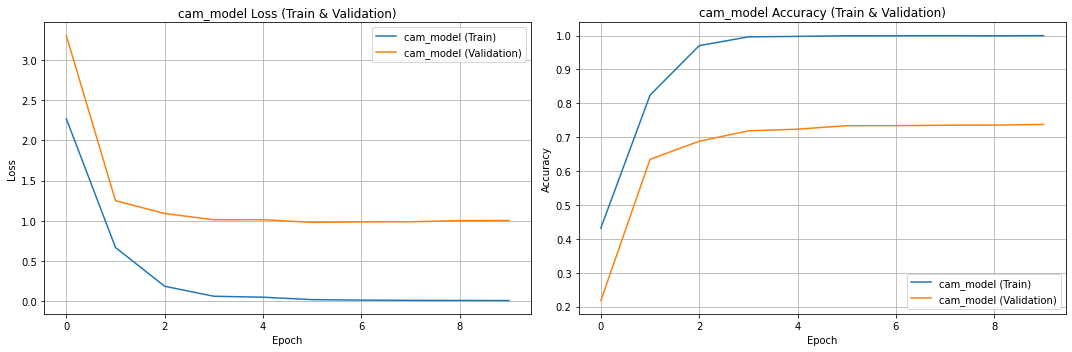

In [15]:
# 저장된 history 가져오기
with open(cam_history_dir_path, 'r') as f:
    read_history = json.load(f)
    
read_history_cam = history_conv(read_history)

print("cam_model")
plot_metrics(read_history_cam, 'cam_model')

### CAM 구현하기
---

1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
```
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image
```

### generate_cam() 구현 

In [16]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) # (Shape: (1, H, W, C))
    conv_outputs = conv_outputs[0, :, :, :] # Shape: (Height, Width, Channels) 
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] # Shape: (특징 맵 채널 수, 클래스 수)
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i] # w_k * f_k(x, y)

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

2. 만든 함수로 CAM 이미지를 생성합시다.
```
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
```

CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [17]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

116


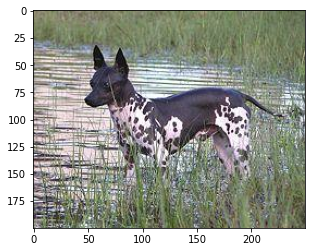

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러오기

In [19]:
import os
# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

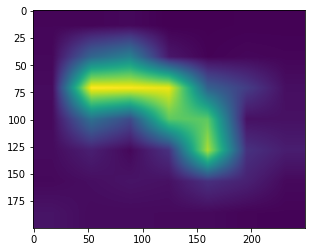

In [24]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

    - webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩  
        https://webnautes.tistory.com/1245  

    ```
    def visualize_cam_on_image(image, cam_image):
        # TODO: blend image
        merged_image = None
        return merged_image
    ```
```
# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
```

In [25]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

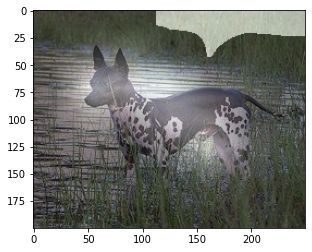

In [26]:
# visualize_cam_on_image() 함수 사용

type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### Grad-CAM 구현하기
---

1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
```
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image
```
2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

### Grad-CAM 구현

- grad_val 을 이용한 weights 과정 식  

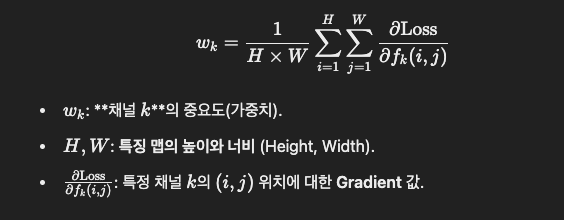

In [27]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0)) # (Shape: (1, H, W, C))
    
        # pred 모델의 최종 예측값 (Softmax 레이어 출력), Shape: (1, 클래스 수) → 1은 배치 차원
        loss = pred[:, class_idx] # 특정 클래스에 대한 예측값 (Loss로 사용), Shape: (1,) → 스칼라값을 포함하는 Tensor.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다. shape: (Height, Width, Channels)
        
        # Gradient의 Shape: (1, Height, Width, Channels) → 배치 차원이 포함
        # [0]: 배치 차원을 제거 shape: (Height, Width, Channels)
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # 각 채널 k에 대한 평균 Gradient, Shape: (Channels,)
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image) # ReLU 적용
    grad_cam_image /= np.max(grad_cam_image) # 정규화
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### 레이어별 CAM 이미지

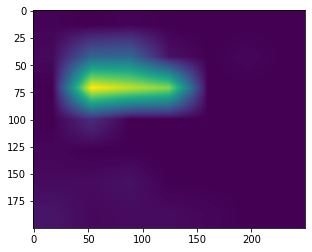

In [28]:
grad_cam_image_1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_1)
plt.show()

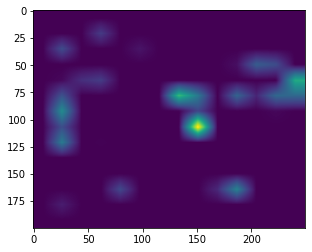

In [29]:
grad_cam_image_2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_2)
plt.show()

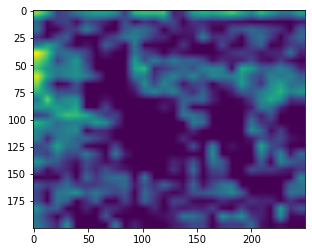

In [30]:
grad_cam_image_3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image_3)
plt.show()

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

### conv5_block3_out 의 visualize_cam_on_image

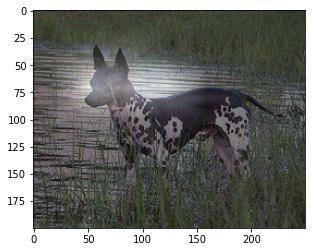

In [31]:
type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image_1*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### conv4_block3_out 의 visualize_cam_on_image

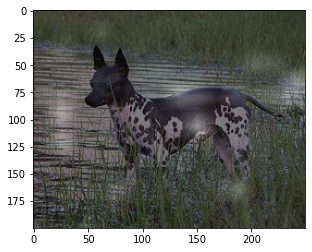

In [32]:
type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image_2*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### conv3_block3_out 의 visualize_cam_on_image

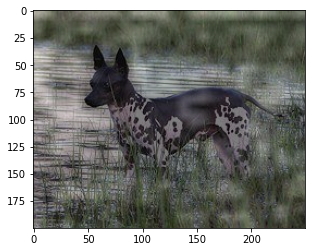

In [33]:
type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image_3*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### 바운딩 박스 구하기
---

1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

### 새로운 이미지 추출

11


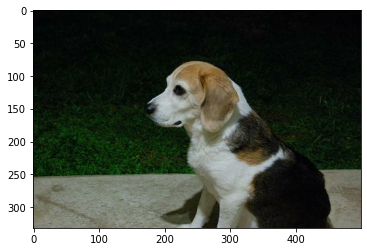

In [49]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### CAM 이미지 생성

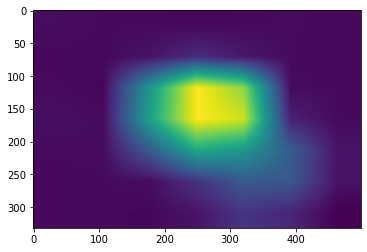

In [50]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

### Grad-CAM 이미지  생성

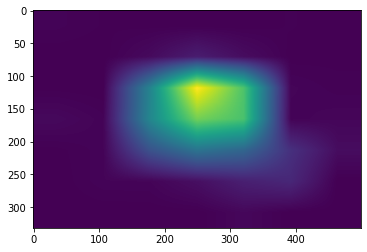

In [51]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### 바운딩 박스 함수 구현

In [52]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

2. 1)에서 얻은 바운딩 박스를 시각화해 보세요.

### CAM 바운딩 박스

In [53]:
cam_rect = get_bbox(cam_image)
cam_rect

array([[113,  48],
       [456,  48],
       [456, 331],
       [113, 331]])

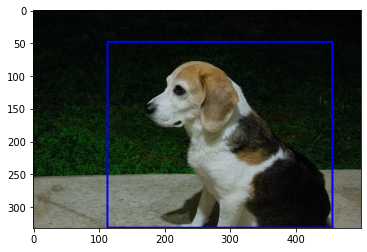

In [54]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [cam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Grad-CAM 바운딩 박스

In [55]:
grad_cam_rect = get_bbox(grad_cam_image)
grad_cam_rect

array([[ 89, 238],
       [132,  29],
       [474,  99],
       [431, 308]])

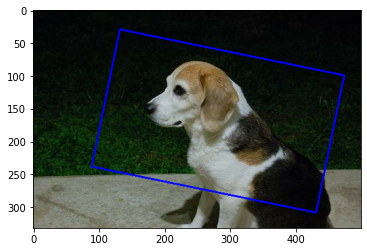

In [56]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_cam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### IoU 구하기
---

1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.
```
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou
```

### get_iou 함수 구현

In [57]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [58]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [59]:
item['objects']['bbox']

array([[0.22289157, 0.326     , 0.9909639 , 0.916     ]], dtype=float32)

### CAM IoU

In [60]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
cam_pred_bbox

[0.14457831325301204, 0.226, 0.9969879518072289, 0.912]

In [61]:
get_iou(cam_pred_bbox, item['objects']['bbox'][0])

0.7656872450602918

### Grad-CAM IoU

In [62]:
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])
grad_cam_pred_bbox

[0.08734939759036145, 0.178, 0.927710843373494, 0.948]

In [63]:
get_iou(grad_cam_pred_bbox, item['objects']['bbox'][0])

0.6076049718317997

### 1차 실험

#### CAM : 0.7820213346220609
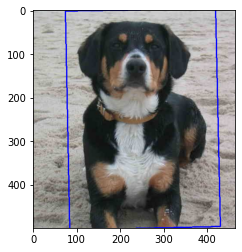

#### Grad-CAM : 0.8485653602038237
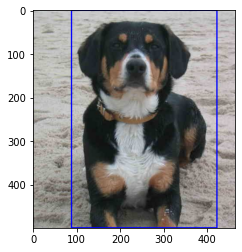  


### 2차 실험

#### CAM : 0.33932350657836025
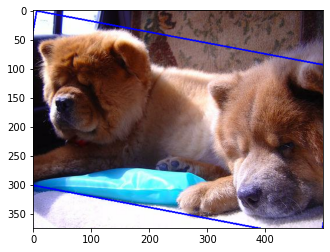

#### Grad-CAM : 0.35944119903963795
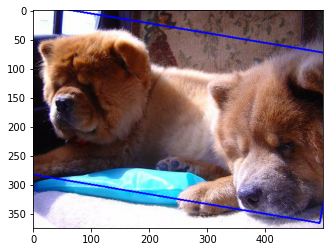

### 3차 실험 : 특이사항 - 이 이미지에서 Grad-CAM 성능이 형편 없이 나왔음

#### CAM : 0.7442278971634074
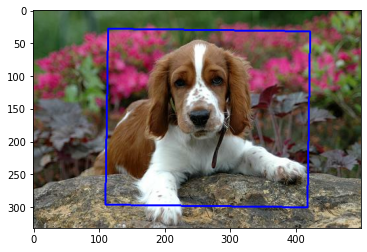

#### Grad-CAM : 0.014612347045090006
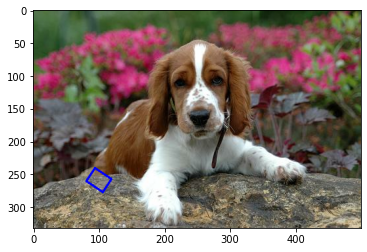

### 4차 실험

#### CAM : 0.6350553913761242
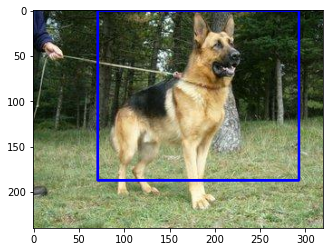

#### Grad-CAM : 0.5072348222341415
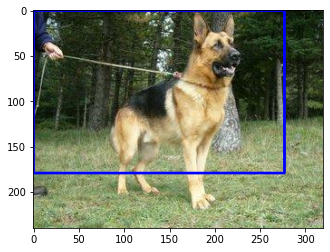

### 5차 실험

#### CAM : 0.6446687770709205
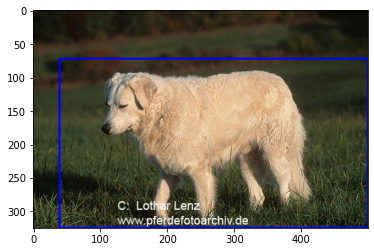

#### Grad-CAM : 0.6376459288903331
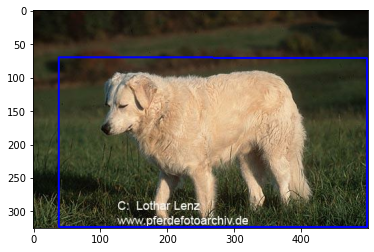

### 6차 실험 : 특이사항 - 이 이미지에서 Grad-CAM 성능이 형편 없이 나왔음

#### CAM : 0.38410006734969915
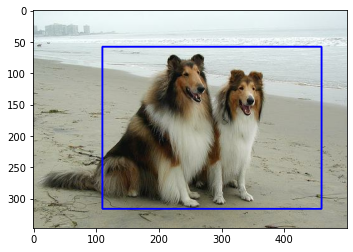

#### Grad-CAM : 0.0
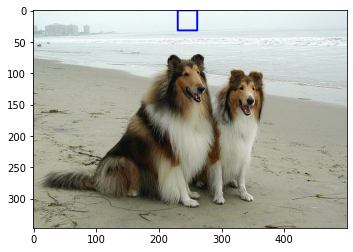

### 회고
- explainable AI 에 대해서 경험 할 수 있는 기회가 되서 유익했다.
- 바운딩박스 regression 없이 CAM 만을 이용해서 바운딩박스를 그릴 수 있다는 것을 알게 되었다.
- Grad-CAM 이나 CAM 을 직접 구현하기에 아직 학습이 부족하다.
- 채널별 특성을 가중치를 이용해 분류 문제 뿐 아니라 위치 정보까지 알아 낼 수 있다는 개념이 아주 신선하게 다가왔다.
- 이미지에 따라 Grad-CAM 이나 CAM 의 IoU 점수가 달라졌다.
- 특히 Grad-CAM 은 2개 사진에서 완전 

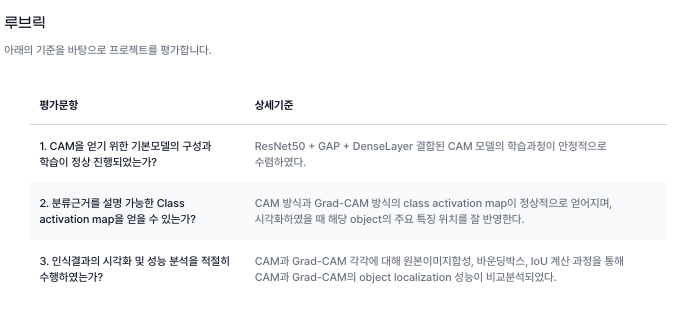